In [ ]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

# Lecture 9. Poisson and beyond.

## Previous lecture
- Reminder about sparse matrices
- About fast direct solvers for sparse solvers

## Todays lecture
- More on elimination and graphs
- FFT method for a Poisson equation
- Sylvester equation

## Model problem

Consider a uniform grid in $\mathbb{R}^d$, 

and the equation 

$$\nabla \cdot k \nabla u = f, \quad u_{\partial \Omega} = 0,$$

$$\Omega = [0, 1]^ d.$$

What is the simplest discretization scheme?

## 1D case

Consider 1D case.

The simple finite-difference approximation is to define $u(x)$ in **integer grid points**, and coefficient $k$ in **half-points**.

Then, 

$$\frac{\partial u}{\partial x}_{i - \frac{1}{2}} \approx \frac{u_{i} - u_{i-1}}{h} + \mathcal{O}(h^2), \quad i = 1, \ldots, N-1,$$

and

$$\left(\frac{\partial}{\partial x} k \frac{\partial u} {\partial x}\right)_i \approx \frac{k_{i+\frac{1}{2}}\frac{\partial u}{\partial x}_{i + \frac{1}{2}} - k_{i-\frac{1}{2}}\frac{\partial u}{\partial x}_{i - \frac{1}{2}}}{h} + \mathcal{O}(h^2)$$

which leads to the final discretization

$$\left(\frac{\partial}{\partial x} k \frac{\partial u} {\partial x}\right)_i \
\approx \frac{k_{i+\frac{1}{2}}\left(u_{i+1} - u_{i}\right) - k_{i-\frac{1}{2}}\left(u_{i} - u_{i-1}\right)}{h^2} + \mathcal{O}(h^2), \quad i = 1, \ldots, n-1, \quad u_0 = u_n = 0.$$

## Matrix form

In the matrix form we get a symmetric, positive-definite tridiagonal matrix $T$ 

with $-k_{i-\frac{1}{2}}$ on subdiagonals, and $\left(k_{i-\frac{1}{2}} + k_{i + \frac{1}{2}}\right)$ on the diagonal.

## Two-dimensional case
In two dimensions,

$$\nabla \cdot k \nabla u = f,$$

for a **diagonal diffusion tensor $k$** 

we have

$$\nabla \cdot k \nabla u = \frac{\partial}{\partial x} K_x \frac{\partial u}{\partial x} + \frac{\partial}{\partial y} K_y \frac{\partial u}{\partial y}, $$

and we discretize each term and get **block tridiagonal matrix with tridiagonal blocks.**

For the simplest $K_x = K_y = I$ we get **2D Poisson problem**,

and the matrix can be written 

$$\Delta_2 = \Delta_1 \otimes I + I \otimes \Delta_1,$$

where $\Delta_1$ is a **one-dimensional** Laplace operator.


## Kronecker product

If $K_x(x, y) = K_x(x)$, and $K_y(x, y) = K_y(y)$, then the div-k-grad operator can be also written in a Kronecker product form

$$A = \Delta_1 \otimes D_1 + D_2 \otimes \Delta_1, $$

where $D_1$ and $D_2$ are diagonal matrices. This happens, for example, in **stratified media**.

In the case when $K_x = K_y = K_1(x) K_2(y)$ the matrix also has the form

$$A = C_1 \otimes D_1 + C_2 \otimes D_2,$$

but now $C_1$ and $C_2$ are (some) tridiagonal matrices.

## Kronecker product

Forgot to give the definition of the Kronecker product, which is an important matrix operation!

Given two matrices $A$ and $B$ of sizes $n_a \times m_a$ and $n_b \times m_n$ their Kronecker product

$$C = A \otimes B$$ is defined as  a matrix of size $(n_a m_a) \times (n_b m_b),$

with a block structure

$$C = [a_{ij} B].$$

## Some properties of the Kronecker product

Kronecker product has many nice properties:

1. $(A \otimes B) (C \otimes D)  = (A C) \otimes (B D)$
2. $(A \otimes B) v = A V B^{\top}$,
if $v = \mathrm{vec}(V)$ (column-by-column vectorization of a matrix).

## Sparse matrices elimination and graphs

In the previous lectures we discussed the connection between graphs and sparse matrices.

Did you get it?



In [9]:
scipy.sparse

<module 'scipy.sparse' from '/home/ivan/miniconda2/lib/python2.7/site-packages/scipy/sparse/__init__.pyc'>

In [30]:
import numpy as np
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
def get_system(n):
    ex = np.ones(n);
    a = scipy.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
    e1 = scipy.sparse.eye(n)
    lp2 = scipy.sparse.kron(e1, a) + scipy.sparse.kron(a, e1)
    lp2 = lp2 * (n + 1) ** 2 #Do not forget.
    return lp2, np.ones(n*n)

n = 6

mat, rhs = get_system(n)

gr = nx.Graph(mat)
mat1 = mat.copy()

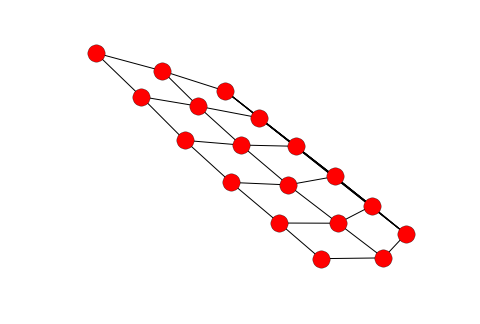

In [48]:
#nx.draw(gr)

mat1 = mat1 - mat1[:, 0:1].dot(mat1[0:1, :])/mat1[0, 0]
mat1 = mat1[1:, :][:, 1:]
nx.draw(nx.Graph(mat1))

## Another permutation

As you see, you get a fully-connected layer during the elimination in the natural order.

Let us take a random permutation..

In [51]:
import numpy as np
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
def get_system(n):
    ex = np.ones(n);
    a = scipy.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
    e1 = scipy.sparse.eye(n)
    lp2 = scipy.sparse.kron(e1, a) + scipy.sparse.kron(a, e1)
    lp2 = lp2 * (n + 1) ** 2 #Do not forget.
    return lp2, np.ones(n*n)

n = 6

mat, rhs = get_system(n)

gr = nx.Graph(mat)
prm = np.arange(n*n, dtype=np.int)
np.random.shuffle(prm)
mat1 = mat.copy()
mat1 = mat1[:, prm][prm, :]

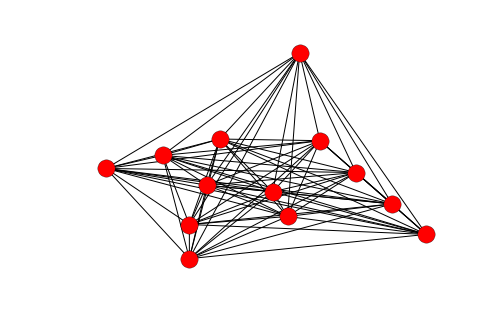

In [74]:
#nx.draw(gr)

mat1 = mat1 - mat1[:, 0:1].dot(mat1[0:1, :])/mat1[0, 0]
mat1 = mat1[1:, :][:, 1:]
mat1[np.abs(mat1) <= 1e-12] = 0.0
mat1.eliminate_zeros()
nx.draw(nx.Graph(mat1))

## Kronecker-based solver

Now let us get back to the Poisson solver.

$$ \Delta_2 = \Delta_1 \otimes I + I \otimes \Delta_1,$$

and we need to solve

$$\Delta_2 u = f.$$

How we can do that? One of the most efficient solvers is the **diagonalization method**.

## Diagonalization method

We have

$$\Delta_2 = \Delta_1 \otimes I + I \otimes \Delta_1.$$

Then, if we decompose

$$\Delta_1 = S \Lambda S^*,$$

where $\Lambda$ is the diagonal matrix, and $SS^* = I$, we have

$$\Delta_2 = S \Lambda S^* \otimes I + I \otimes S \Lambda S^* = \left(S \otimes S\right)\left(\Lambda \otimes I + I \otimes \Lambda\right)\left(S^* \otimes S^*\right).$$

Moreover, since

$$(A \otimes B)^{-1} = A^{-1} \otimes B^{-1},$$

and $$(S \otimes S)^{-1} = S^{-1} \otimes S^{-1} = S^* \otimes S^* $$

we have


$$\Delta^{-1}_2 = (S \otimes S)(\Lambda \otimes I + I \otimes \Lambda)^{-1} (S^* \otimes S^*).$$

## Final formula

$$\Delta^{-1}_2 = (S \otimes S)(\Lambda \otimes I + I \otimes \Lambda)^{-1} (S^* \otimes S^*).$$
The matrix

$$\Lambda_2 = \Lambda \otimes I + I \otimes \Lambda$$ is a **diagonal matrix**, thus its inversion costs $\mathcal{O}(N)$.

The multiplication by $S \otimes S$ and by $S^* \otimes S^*$ is more interesting.

If we reshape the unknown vector into a $n \times n$ matrix, we will have

$$(S \otimes S) \mathrm{vec}(X) = S X S^{\top},$$

which amounts to the application of $S$ to the columns of $X$ and then $S$ to the rows of $X$.

If $S$ does not have any structure, we have $\mathcal{O}(n^3)$ complexity.

For the Laplace equation, we all know the eigenvalues/eigenvectors of 1D Laplacian matrix, 

and $S$ is the **sine Fourier transform.** which takes $\mathcal{O}(n)$ for each column,, 

thus the total complexity is $\mathcal{O}(n^2) = \mathcal{O}(N)$.

## Summary on diagonalization

To summarize, the final complexity is:

1. Apply 2D sine FFT
2. Multiply element-wise
3. Apply inverse 2D FFT.

The final cost is $\mathcal{O}(N \log N)$ with a small constant

In 3D it is absolutely the same.

## Note on a more general case

If the matrix $C = A \otimes B$,

then

$$C^{-1} = A^{-1} \otimes B^{-1}$$ 

and the problem is reduced to $2n$ one-dimensional problems.

For a more general **Kronecker-rank 2** case

$$C = A_1 \otimes B_1 + A_2 \otimes B_2,$$

the linear system

$$C x = f$$ is equivalent to the so-called **Sylvester equation**

$$A_1 X B^{\top}_1 + A_2 X B^{\top}_2 = F.$$

## Sylvester equation
$$A_1 X B^{\top}_1 + A_2 X B^{\top}_2 = F.$$

The number of unknowns is $n^2$, thus using LU-decomposition will give you $\mathcal{O}(n^6)$ complexity. However, we can do $\mathcal{O}(n^3)$.

Every pair of matrices can be brought to the triangular form by **generalized Schur decomposition:**

$$A_1 = Q_1 T_1 Z^{\top}_1, \quad A_2 = Q_2 T_2 Z^{\top}_2, $$

And the matrices $A_1$, $A_2$, $B_1$, $B_2$ can be considered **triangular**.

This costs $\mathcal{O}(n^3)$ 

## Solving triangular Sylvester equation

The triangular Sylvester equation has the form

$$T_1 Y T^{\top}_2 + T_3 Y \otimes T^{\top}_4 = G, $$

or 

$$(T_1 \otimes T_2 + T_3 \otimes T_4) y = g.$$

This is a block-triangular linear system that can be solved in $\mathcal{O}(n^3)$ operations!


## Summary
- Demo on elimination
- 1D Poisson solver
- Sylvester equation

## Next lecture
- Multigrid

In [40]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()